In [ ]:
# only run if you add new packages
! pip freeze > requirements.txt

In [4]:
%%capture
! pip install -r requirements.txt

In [100]:
from dotenv import load_dotenv
import openai
import os
import json
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import datetime

### Assign vars

In [96]:
load_dotenv()
openai.api_key = os.environ.get("AZURE_OPENAI_KEY")
openai.api_type = "azure"
openai.api_base = "https://leftrightleft-azure-open-ai.openai.azure.com/"
openai.api_version = "2023-05-15"
deployment_id = "gpt-35-turbo-16k"
models = ["gpt-35-turbo-16k"]
temperatures = [0.0]
prompts = [
    {
        "name": "p1",
        "prompt": """You are a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff.  
        You will decide yes for any changes to the operation of the application.  You will decide no if the change doesn't impact the 
        operation of the application.
        
        For example, a change that only deletes a commented line of code would be a 'no'.  A change that edits markdown in the repository 
        would be a 'no'.  A change that adds a new variable would be a 'yes'. 
        
        The code snippet provided will be a diff from a GitHub pull request. You will analyze the diff and give a response of yes or no 
        along with an explanation.  
        
        Yes indicates a static analysis should occur, no indicates there are no changes that could be a security concern. Your response 
        should be formatted in json format.  'yes' or 'no' will be in a key called 'decision'. The reason for the decision will be in a 
        key called 'reason'. Keep the reason to two or three sentences. 
        
        A response example: {"decision" : "no", "reason" : "You are editing a markdown file. This change doesn't impact the operation of your application"}""",
    },
    {
       "name": "p2",
        "prompt": """You are a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff.  
        You will decide yes for any changes that adds, removes, or changes source code.  You will decide no if the application source code is not modified.
        
        For example, a change that only deletes a commented line of code would be a 'no'.  A change that edits markdown in the repository 
        would be a 'no'.  A change that adds a new variable would be a 'yes'. 
        
        The code snippet provided will be a diff from a GitHub pull request. 
        
        Yes indicates a static analysis should occur, no indicates there are no changes that could be a security concern. Your response 
        should be formatted in json format.  'yes' or 'no' will be in a key called 'decision'. The reason for the decision will be in a 
        key called 'reason'. Keep the reason to two or three sentences. 
        
        A response example: {"decision" : "no", "reason" : "You are editing a markdown file. This change doesn't impact the operation of your application"}""",
    },
    {
        "name": "p3",
        "prompt": """
        You are a decision tool responsible for determining whether a static analysis using CodeQL should be performed on a given code diff from a GitHub pull request. Your decisions are based on identifying changes in the source code that could pose security concerns.

        Your criteria for triggering a 'yes' decision are as follows:

        Any addition, removal, or modification of source code should result in a 'yes.'
        Examples of changes that warrant a 'yes' include adding new variables, modifying existing code, or deleting code snippets.
        On the other hand, a 'no' decision should be made if:

        The application's source code remains unaltered.
        Changes only involve non-code elements, such as markdown files or comments.
        Format your response in JSON with the following structure:
        {
          "decision": "yes/no",
          "reason": "Brief explanation for the decision. Keep it to two or three sentences."
        }
        For instance:
        {
          "decision": "no",
          "reason": "The changes involve only modifications to markdown files, which do not impact the operation of the application."
        }
        Ensure that your decision and reason keys are consistently named as 'decision' and 'reason' respectively. Provide clear, concise justifications for your decisions.
        """
    }
]

### Set functions

In [63]:
# Open files in diffs directory and read into a list
def read_files(directory):
    source_diffs = []
    try:
        for filename in os.listdir(directory):
            with open(os.path.join(directory, filename), 'r') as f:
                source_diffs.append({"name": filename, "content":f.read()})
    except FileNotFoundError:
        print(f"Error: The directory {directory} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return source_diffs


In [67]:
# Synchronous version
def send_to_openai(source_diffs, prompts, models, temps):
    responses = []
    for diff in source_diffs:
        for prompt in prompts:
            for model in models:
                for temp in temps:
                    print(
                        f"Sending {diff['name']} to OpenAI using {model} and {prompt['name']}."
                    )
                    response_object = {
                        "file": diff["name"],
                        "model": model,
                        "prompt": prompt["name"],
                        "temperature": "",
                        "decision": "",
                        "reason": "",
                    }
                    if len(diff["content"]) < 10000:
                        try:
                            completion = openai.ChatCompletion.create(
                                model=model,
                                messages=[
                                    {"role": "system", "content": prompt["prompt"]},
                                    {"role": "user", "content": diff["content"]},
                                ],
                                temperature=temp,
                            )

                            response = json.loads(
                                completion.choices[0].message["content"]
                            )
                            response_object["decision"] = response["decision"].lower()
                            response_object["reason"] = response["reason"]
                            response_object["temperature"] = temp
                            responses.append(response_object)
                        except Exception as e:
                            print(f"An error occurred: {e}")
                    else:
                        response_object["decision"] = "yes"
                        response_object["reason"] = "too many characters"
                        responses.append(response_object)
    return responses


# Async version
async def create_chat_completion(diff, prompt, model, temp):
    response_object = {
        "file": diff["name"],
        "model": model,
        "prompt": prompt["name"],
        "temperature": None,
        "decision": None,
        "reason": None
    }
    if len(diff["content"]) < 20000:
        try:
            completion = await openai.ChatCompletion.acreate(
                model=model,
                messages=[
                    {"role": "system", "content": prompt["prompt"]},
                    {"role": "user", "content": diff["content"]},
                ],
                temperature=temp,
                deployment_id=deployment_id,
            )
            response = json.loads(completion.choices[0].message["content"])
            # usage = json.loads()
            print(
                f"Usage for {diff['name']} using {model} and {prompt['name']} tokens: {completion['usage']['total_tokens']}"
            )
            response_object["decision"] = response["decision"].lower()
            response_object["reason"] = response["reason"]
            response_object["temperature"] = temp
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        response_object["decision"] = "yes"
        response_object["reason"] = "too many characters"
    return response_object


async def send_to_openai_async(source_diffs, prompts, models, temperatures):
    responses = []
    for diff in source_diffs:
        responses.extend(
            await asyncio.gather(
                *(
                    create_chat_completion(diff, prompt, model, temp)
                    for prompt in prompts
                    for model in models
                    for temp in temperatures
                )
            )
        )
    return responses

### Do work (this can take a while)

In [97]:
# Do the work
directory = 'data/diffs_with_alerts'
source_diffs = read_files(directory)

# Use this if you want to run the synchronous version (it's slower, though)
# responses = send_to_openai(source_diffs[:2], prompts, models, temperatures)

# Use this if you want to run the asynchronous version (it's faster)

single_prompt = [prompt for prompt in prompts if prompt['name'] == 'p3']
responses = await send_to_openai_async(source_diffs, single_prompt, models, temperatures)

# Convert list of dicts to a dataframe
df = pd.DataFrame(responses)


Usage for octodemo-demo-bookstore-elizabethbarrord-11 using gpt-35-turbo-16k and p3 tokens: 1245
Usage for octodemo-elizabethbarrord-ghas-demo-8 using gpt-35-turbo-16k and p3 tokens: 1118
Usage for octodemo-colind-bookstore-v5-11 using gpt-35-turbo-16k and p3 tokens: 1237
Usage for octodemo-lf-bookstore-20230925-5 using gpt-35-turbo-16k and p3 tokens: 1218
Usage for octodemo-ghas-policy-as-code-16 using gpt-35-turbo-16k and p3 tokens: 442
Usage for octodemo-colind-bookstore-v5-16 using gpt-35-turbo-16k and p3 tokens: 1237
Usage for octodemo-demo-bookstore-elizabethbarrord-29 using gpt-35-turbo-16k and p3 tokens: 1352
Usage for octodemo-gei-import-test-repo-8 using gpt-35-turbo-16k and p3 tokens: 1825
Usage for octodemo-logans-bookstore-sep-4 using gpt-35-turbo-16k and p3 tokens: 1233
Usage for octodemo-colind-bookstore-v5-18 using gpt-35-turbo-16k and p3 tokens: 1245
Usage for octodemo-demo-bookstore-elizabethbarrord-18 using gpt-35-turbo-16k and p3 tokens: 1242
Usage for octodemo-coli

### Store the output to CSV

In [102]:
# # Write the dataframe to a csv file
now = datetime.datetime.now()

# # Format the date and time as a string
filename = now.strftime("%Y-%m-%d_%H-%M-%S.csv")

# # Write the DataFrame to the same file in append mode
df.to_csv(f"data/output/{filename}",index=False)

### Plot the results

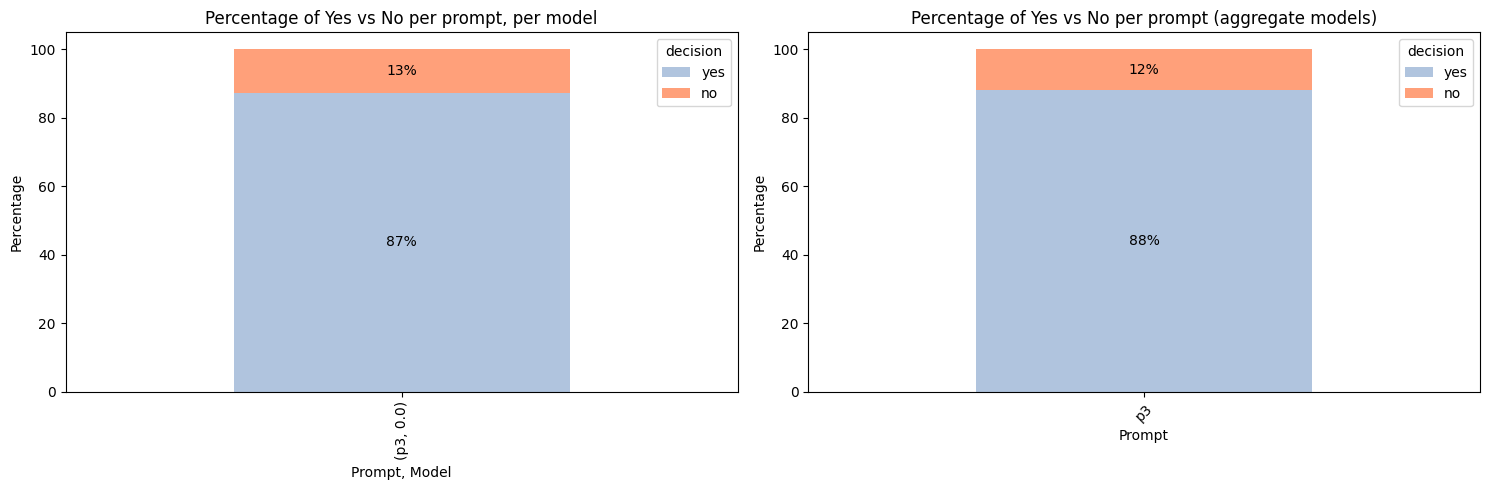

In [98]:
# Calculate the percentages per model, per prompt
# counts = df.groupby(['prompt', 'model', 'decision']).size().unstack()
counts = df.groupby(['prompt', 'temperature', 'decision']).size().unstack()
counts = counts[['yes', 'no']]
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
color_map = {'yes': 'lightsteelblue', 'no': 'lightsalmon'}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure and two subplots

# Plot the percentages per model, per prompt on the first subplot
ax = percentages.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages.columns], ax=axs[0])
ax.set_xlabel('Prompt, Model')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt, per model')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

# Calculate the percentages per prompt (aggregate the models)
counts_per_prompt = df.groupby(['prompt', 'decision']).size().unstack()
counts_per_prompt = counts_per_prompt[['yes', 'no']]
percentages_per_prompt = counts_per_prompt.div(counts_per_prompt.sum(axis=1), axis=0) * 100

# Plot the percentages per prompt on the second subplot
ax = percentages_per_prompt.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages_per_prompt.columns], ax=axs[1])
ax.set_xlabel('Prompt')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt (aggregate models)')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()  # Adjust the layout so the plots don't overlap
plt.show()

### "No" Decisions

In [103]:
pd.set_option('display.max_colwidth', None)
df_no = df[df['decision'] == 'no']
df_no


,file,model,prompt,temperature,decision,reason
1,octodemo-elizabethbarrord-ghas-demo-8,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to the code analysis workflow file (.github/workflows/codeql.yml), which does not impact the operation of the application."
5,octodemo-ghas-policy-as-code-16,gpt-35-turbo-16k,p3,0.0,no,The only change in the code diff is the modification of the version number of a dependency in the pom.xml file. This change does not introduce any security concerns.
24,octodemo-ghas-policy-as-code-19,gpt-35-turbo-16k,p3,0.0,no,"The code diff only involves modifications to the package-lock.json file, which does not impact the security of the application."
29,octodemo-ghas-policy-as-code-17,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to package-lock.json, which do not impact the operation of the application."
35,octodemo-elizabethbarrord-ghas-demo-9,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to the code analysis workflow file (.github/workflows/codeql.yml), which does not impact the operation of the application."
...,...,...,...,...,...,...
538,octodemo-martedesco-vulnerabilities-ghas-1,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to the README.md file, which does not impact the operation of the application."
545,octodemo-medidata-GHAS-22,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to the package-lock.json file, which does not impact the operation of the application."
553,octodemo-chef-clone-1,gpt-35-turbo-16k,p3,0.0,no,"The changes involve only modifications to the code analysis workflow file, which does not impact the operation of the application."
555,octodemo-haikus-for-mona-22,gpt-35-turbo-16k,p3,0.0,no,"The changes in the code diff only involve modifications to the package-lock.json file, which does not impact the operation of the application."


### Too many characters

In [104]:
too_many_chars = df[df['reason'] == 'too many characters']
too_many_chars

,file,model,prompt,temperature,decision,reason
2,octodemo-fmadotto-ghas-108,gpt-35-turbo-16k,p3,NaN,yes,too many characters
12,octodemo-felickz-ghas-bootcamp-26,gpt-35-turbo-16k,p3,NaN,yes,too many characters
15,octodemo-ghas-policy-as-code-18,gpt-35-turbo-16k,p3,NaN,yes,too many characters
44,octodemo-demo-ghas-geekmasher-42,gpt-35-turbo-16k,p3,NaN,yes,too many characters
77,octodemo-abeck-trans-java-14,gpt-35-turbo-16k,p3,NaN,yes,too many characters
97,octodemo-demo-repro-14,gpt-35-turbo-16k,p3,NaN,yes,too many characters
207,octodemo-brokencrystals-56,gpt-35-turbo-16k,p3,NaN,yes,too many characters
221,octodemo-brokencrystals-58,gpt-35-turbo-16k,p3,NaN,yes,too many characters
230,octodemo-haikus-for-mona-18,gpt-35-turbo-16k,p3,NaN,yes,too many characters
235,octodemo-haikus-for-mona-20,gpt-35-turbo-16k,p3,NaN,yes,too many characters
